In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [2]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

import numpy as np

batch_size = 256
image_dim = 784  # [flattened]

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.autonotebook import tqdm
from itertools import chain


class DN_Encoder(nn.Module):
    '''
    Denoising encoder with a single input, hidden and output layer
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DN_Encoder, self).__init__()
        # YOUR CODE HERE
        self.fc_hidden = nn.Linear(input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # YOUR CODE HERE
        out = self.fc_hidden(x).relu()
        return self.fc_out(out)

        
class DN_Decoder(nn.Module):
    '''
    Denoising decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DN_Decoder, self).__init__()
        # YOUR CODE HERE
        self.fc_hidden = nn.Linear(input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # YOUR CODE HERE
        out = self.fc_hidden(x)
        out = self.fc_out(out)
        return torch.sigmoid(out)

  0%|          | 0/235 [00:00<?, ?it/s]

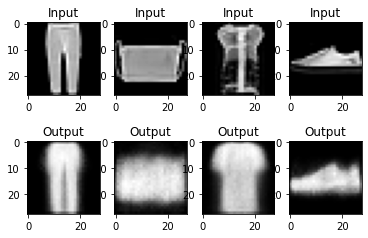

  0%|          | 0/235 [00:00<?, ?it/s]

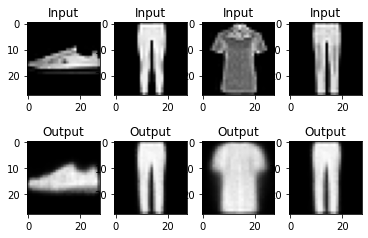

  0%|          | 0/235 [00:00<?, ?it/s]

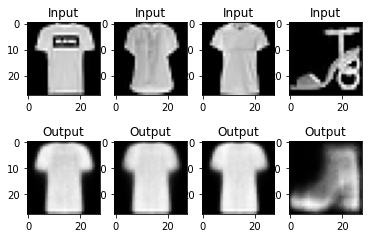

  0%|          | 0/235 [00:00<?, ?it/s]

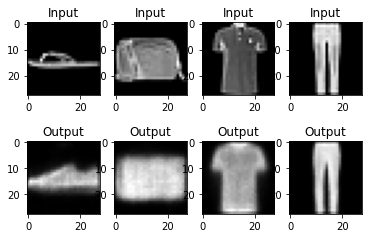

  0%|          | 0/235 [00:00<?, ?it/s]

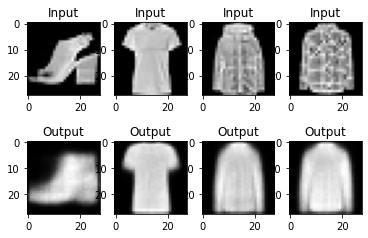

  0%|          | 0/235 [00:00<?, ?it/s]

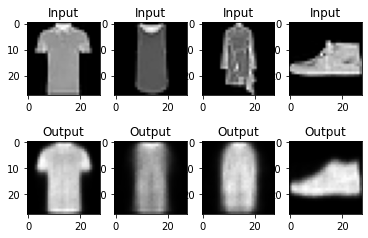

  0%|          | 0/235 [00:00<?, ?it/s]

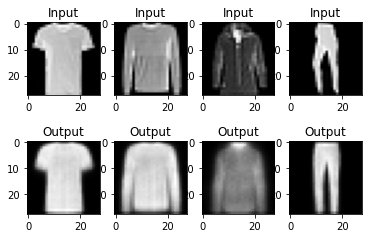

  0%|          | 0/235 [00:00<?, ?it/s]

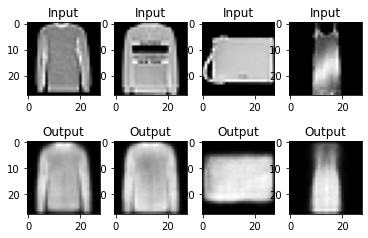

  0%|          | 0/235 [00:00<?, ?it/s]

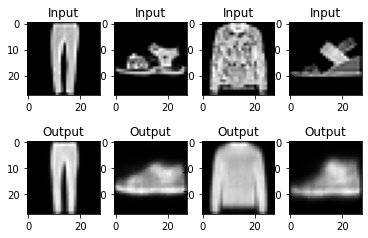

  0%|          | 0/235 [00:00<?, ?it/s]

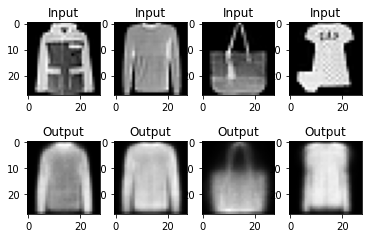

In [4]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec    
import os
import torch.optim as optim
import numpy as np

from tqdm.autonotebook import tqdm
from itertools import chain

enc_dim = 64
hidden_dim = 128
image_dim = 784
nEpoch = 10

enc = DN_Encoder(image_dim, hidden_dim, enc_dim)
dec = DN_Decoder(enc_dim, hidden_dim, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        optimizer.zero_grad()

        noise = torch.normal(0, 1, size=inputs.shape)
        noisy_inputs = inputs + noise
        z = enc(noisy_inputs)
        outputs = dec(z)

        loss = F.binary_cross_entropy(outputs, inputs, reduction='sum') / inputs.shape[0]
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
    
    
    ## Display some of the reconstructed images
    # YOUR CODE HERE
    with torch.no_grad():
        inputs, _ = next(iter(trainloader))
        z = enc(inputs)
        outputs = dec(z)

        inputs = inputs.view(inputs.shape[0], 28, 28)
        outputs = outputs.view(outputs.shape[0], 28, 28)
        randidx = torch.randint(outputs.shape[0], (4,))
        for i in range(8):
            plt.subplot(int(str(24)+str(i+1)))
            if i < 4:
                plt.title("Input")
                plt.imshow(inputs[randidx[i]], cmap=plt.get_cmap('gray'))
            else:
                plt.title("Output")
                plt.imshow(outputs[randidx[i-4]], cmap=plt.get_cmap('gray'))
        plt.show()